In [2]:
#Changer le répertoire courant pour l'import des modules
import os

current_dir = os.getcwd()

target_dir = os.path.abspath(os.path.join(current_dir, '..'))

os.chdir(target_dir)
print(os.getcwd())

c:\Users\CS\Documents\Projet_Radiotherapie\projet_S7_radio


In [3]:
from loadData import ThoraxDataLoader
import SimpleITK 
import skimage.io as io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.nn.functional as F

from matplotlib import cm
from matplotlib.colors import ListedColormap

from tqdm import tqdm

In [5]:
loader = ThoraxDataLoader("./Data/Data_Medical/MCsimulations")
LS_dataset = loader.load_all_samples("LS")
CT_dataset = loader.load_all_samples("CT")
y_dataset = loader.load_all_samples("HS")
newcmp = loader.newcmp

sample_0001 chargé avec succès.
sample_0002 chargé avec succès.
sample_0003 chargé avec succès.
sample_0004 chargé avec succès.
sample_0005 chargé avec succès.
sample_0006 chargé avec succès.
sample_0007 chargé avec succès.
sample_0008 chargé avec succès.
sample_0009 chargé avec succès.
sample_0010 chargé avec succès.
sample_0011 chargé avec succès.
sample_0012 chargé avec succès.
sample_0013 chargé avec succès.
sample_0014 chargé avec succès.
sample_0015 chargé avec succès.
sample_0016 chargé avec succès.
sample_0017 chargé avec succès.
sample_0018 chargé avec succès.
sample_0019 chargé avec succès.
sample_0020 chargé avec succès.
sample_0021 chargé avec succès.
sample_0022 chargé avec succès.
sample_0023 chargé avec succès.
sample_0024 chargé avec succès.
sample_0025 chargé avec succès.
sample_0026 chargé avec succès.
sample_0027 chargé avec succès.
sample_0028 chargé avec succès.
sample_0029 chargé avec succès.
sample_0030 chargé avec succès.
sample_0031 chargé avec succès.
sample_0

In [7]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, img_size):
        super(TransformerBlock, self).__init__()
        self.img_size = img_size
        self.flatten_dim = img_size * img_size

        encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        assert height == self.img_size and width == self.img_size, "Input image size must match transformer input size."

        x = x.flatten(2).permute(2, 0, 1)  # (batch, channels, height*width) -> (height*width, batch, channels)
        x = self.transformer(x)
        x = x.permute(1, 2, 0).reshape(batch_size, channels, height, width)  # Restore shape

        return x

class UNetWithTransformer(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=64, embed_dim=256, num_heads=8, num_layers=4, img_size=128):
        super(UNetWithTransformer, self).__init__()
        
        # Encoder
        self.enc1 = ConvBlock(in_channels, base_channels)
        self.enc2 = ConvBlock(base_channels, base_channels * 2)
        self.enc3 = ConvBlock(base_channels * 2, base_channels * 4)
        self.enc4 = ConvBlock(base_channels * 4, base_channels * 8)
        
        # Transformer block
        self.transformer = TransformerBlock(embed_dim, num_heads, num_layers, img_size // 16)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.up3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_channels * 8, base_channels * 4)
        
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_channels * 4, base_channels * 2)
        
        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_channels * 2, base_channels)
        
        self.up0 = nn.ConvTranspose2d(base_channels, base_channels, kernel_size=2, stride=2)
        self.final = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Transformer
        bottleneck = self.pool(enc4)
        bottleneck = self.transformer(bottleneck)

        # Decoder
        dec3 = self.dec3(torch.cat([self.up3(bottleneck), self.pool(enc3)], dim=1))
        dec2 = self.dec2(torch.cat([self.up2(dec3), self.pool(enc2)], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), self.pool(enc1)], dim=1))
        return self.final(self.up0(dec1))

# Exemple d'initialisation du modèle
model = UNetWithTransformer(
    in_channels=2, 
    out_channels=1, 
    base_channels=64, 
    embed_dim=512, 
    num_heads=8, 
    num_layers=4, 
    img_size=64
)

# Affichage de la structure du modèle
print(model)


UNetWithTransformer(
  (enc1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(128, 256, 

In [12]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS_train = torch.tensor(LS_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_train = torch.tensor(CT_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_train = torch.cat((LS_train, CT_train), dim=1)
y_train = torch.tensor(y_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)

LS_val = torch.tensor(LS_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_val = torch.tensor(CT_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_val = torch.cat((LS_val, CT_val), dim=1)
y_val = torch.tensor(y_dataset[train_lenght:val_lenght,:,:],  dtype=torch.float32).unsqueeze(1)

LS_test = torch.tensor(LS_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
CT_test = torch.tensor(CT_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
x_test = torch.cat((LS_test, CT_test), dim=1)
y_test = torch.tensor(y_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

(torch.Size([4592, 2, 64, 64]),
 torch.Size([4592, 1, 64, 64]),
 torch.Size([656, 2, 64, 64]),
 torch.Size([656, 1, 64, 64]),
 torch.Size([1312, 2, 64, 64]),
 torch.Size([1312, 1, 64, 64]))

In [13]:
batch_size = 10

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout, etc.)
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Passage dans le modèle
            outputs = model(inputs)
            
            # Calcul de la perte
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Collecter les prédictions et les vraies étiquettes
            preds = outputs.argmax(dim=1)  # Utilisez `argmax` si c'est une tâche de classification multi-classe
            all_preds.extend(preds.cpu().numpy())  # Déplacer les prédictions vers le CPU et les collecter
            all_targets.extend(targets.cpu().numpy())  # Idem pour les cibles
            
    # Calcul de la perte moyenne de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")
    return val_loss

In [10]:
def calculate_psnr(original, reconstructed, data_range=1.0):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return np.inf
    psnr = 10*np.log10(data_range**2 / mse)
    return psnr

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.L1Loss()  # Loss pour le débruitage
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 250

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Déplacer vers GPU si disponible

        # Initialiser les gradients
        optimizer.zero_grad()

        # Passer les données dans le modèle
        outputs = model(inputs)

        # Calculer la perte
        loss = criterion(outputs, targets)

        # Rétropropagation
        loss.backward()

        # Mise à jour des poids
        optimizer.step()

        # Accumuler la perte
        running_loss += loss.item()

        # Afficher la perte
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss:.4f}")
    
    # Évaluation sur le jeu de validation
    evaluate_model(model, val_loader, criterion, device)

    # Vous pouvez ajouter des fonctions d'évaluation ici (sur un jeu de validation, par exemple)

torch.save(model.state_dict(), r"ApplicationsUNet\UNet LS+CT-HS\models\UNet.pth")
print("Entraînement terminé")

Epoch [1/250], Batch [1/460], Loss: 0.0026
Epoch [1/250], Batch [2/460], Loss: 0.0037
Epoch [1/250], Batch [3/460], Loss: 0.0030
Epoch [1/250], Batch [4/460], Loss: 0.0027
Epoch [1/250], Batch [5/460], Loss: 0.0029
Epoch [1/250], Batch [6/460], Loss: 0.0031
Epoch [1/250], Batch [7/460], Loss: 0.0031
Epoch [1/250], Batch [8/460], Loss: 0.0028
Epoch [1/250], Batch [9/460], Loss: 0.0031
Epoch [1/250], Batch [10/460], Loss: 0.0030
Epoch [1/250], Batch [11/460], Loss: 0.0028
Epoch [1/250], Batch [12/460], Loss: 0.0025
Epoch [1/250], Batch [13/460], Loss: 0.0027
Epoch [1/250], Batch [14/460], Loss: 0.0028
Epoch [1/250], Batch [15/460], Loss: 0.0027
Epoch [1/250], Batch [16/460], Loss: 0.0028
Epoch [1/250], Batch [17/460], Loss: 0.0025
Epoch [1/250], Batch [18/460], Loss: 0.0024
Epoch [1/250], Batch [19/460], Loss: 0.0026
Epoch [1/250], Batch [20/460], Loss: 0.0028
Epoch [1/250], Batch [21/460], Loss: 0.0029
Epoch [1/250], Batch [22/460], Loss: 0.0023
Epoch [1/250], Batch [23/460], Loss: 0.00

In [18]:
train_loss_history = []
val_loss_history = []
min_loss = np.inf
min_epoch = -1
patience_counter = 0

patience = 20
num_epochs = 250

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):

  print('Epoch %d/%d\n' % (epoch+1, num_epochs))

  # Training
  model.train()
  train_loss = []

  for batch_idx, (data, target) in tqdm(enumerate(train_loader),
                                        total=len(train_loader)):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    model_output = model(data)
    loss = criterion(model_output, target)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item()*len(data))

  train_loss_history.append(np.sum(train_loss)/len(train_dataset))
  print('Training loss: {}'.format(train_loss_history[-1]))

  # Validation
  model.eval()
  val_loss = []

  with torch.no_grad():
    for batch_idx, (data, target) in tqdm(enumerate(val_loader),
                                        total=len(val_loader)):
      
      data, target = data.to(device), target.to(device)
      model_output = model(data)
      loss = criterion(model_output, target)
      val_loss.append(loss.item()*len(data))

    val_loss_history.append(np.sum(val_loss)/len(val_dataset))
    print('Validation loss: {}\n'.format(val_loss_history[-1]))

  # model saving
  if min_loss > val_loss_history[-1]:

    # update best loss
    min_epoch = epoch
    min_loss = val_loss_history[-1]

    # save model
    model_path = 'best_model.pth'
    best_state_dict = model.state_dict()
    torch.save(best_state_dict, model_path)

  # early stopping
  if len(val_loss_history) >= 2:

    if val_loss_history[-1] > min_loss:
      patience_counter+=1
    else:
      patience_counter = 0

  if patience_counter >= patience:
    print('Training done!')
    break

Epoch 1/250



100%|██████████| 460/460 [00:10<00:00, 45.54it/s]


Training loss: 0.0002512453118768031


100%|██████████| 66/66 [00:00<00:00, 182.57it/s]


Validation loss: 0.00024324205521513315

Epoch 2/250



100%|██████████| 460/460 [00:10<00:00, 45.74it/s]


Training loss: 0.00021352644081361642


100%|██████████| 66/66 [00:00<00:00, 190.43it/s]


Validation loss: 0.00021158367479340708

Epoch 3/250



100%|██████████| 460/460 [00:09<00:00, 46.05it/s]


Training loss: 0.0001869848336367738


100%|██████████| 66/66 [00:00<00:00, 194.32it/s]


Validation loss: 0.0001952919397675631

Epoch 4/250



100%|██████████| 460/460 [00:10<00:00, 45.95it/s]


Training loss: 0.0001692991849305883


100%|██████████| 66/66 [00:00<00:00, 196.96it/s]


Validation loss: 0.00017989235624465836

Epoch 5/250



100%|██████████| 460/460 [00:09<00:00, 46.25it/s]


Training loss: 0.0001530253900046339


100%|██████████| 66/66 [00:00<00:00, 201.04it/s]


Validation loss: 0.00017937938401900748

Epoch 6/250



100%|██████████| 460/460 [00:09<00:00, 46.14it/s]


Training loss: 0.00013710288529987353


100%|██████████| 66/66 [00:00<00:00, 200.24it/s]


Validation loss: 0.0002664112104268009

Epoch 7/250



100%|██████████| 460/460 [00:09<00:00, 46.40it/s]


Training loss: 0.0001258976258704997


100%|██████████| 66/66 [00:00<00:00, 201.09it/s]


Validation loss: 0.0005623661665328943

Epoch 8/250



100%|██████████| 460/460 [00:09<00:00, 46.25it/s]


Training loss: 0.00012008779581914755


100%|██████████| 66/66 [00:00<00:00, 200.60it/s]


Validation loss: 0.00018713255944820094

Epoch 9/250



100%|██████████| 460/460 [00:09<00:00, 46.41it/s]


Training loss: 0.0001222201588537813


100%|██████████| 66/66 [00:00<00:00, 200.00it/s]


Validation loss: 0.00015294454790752598

Epoch 10/250



100%|██████████| 460/460 [00:09<00:00, 46.28it/s]


Training loss: 0.00011037025850678235


100%|██████████| 66/66 [00:00<00:00, 197.99it/s]


Validation loss: 0.00015509328493020047

Epoch 11/250



100%|██████████| 460/460 [00:09<00:00, 46.30it/s]


Training loss: 0.00010336902272278172


100%|██████████| 66/66 [00:00<00:00, 200.00it/s]


Validation loss: 0.0002109029897704803

Epoch 12/250



100%|██████████| 460/460 [00:09<00:00, 46.32it/s]


Training loss: 0.00010257916568256411


100%|██████████| 66/66 [00:00<00:00, 199.47it/s]


Validation loss: 0.0002870895195661522

Epoch 13/250



100%|██████████| 460/460 [00:09<00:00, 46.31it/s]


Training loss: 9.555781219424187e-05


100%|██████████| 66/66 [00:00<00:00, 189.18it/s]


Validation loss: 0.00015418131266503734

Epoch 14/250



100%|██████████| 460/460 [00:09<00:00, 46.34it/s]


Training loss: 9.056680495100077e-05


100%|██████████| 66/66 [00:00<00:00, 198.34it/s]


Validation loss: 0.00013911638507124735

Epoch 15/250



100%|██████████| 460/460 [00:09<00:00, 46.18it/s]


Training loss: 9.125982659615074e-05


100%|██████████| 66/66 [00:00<00:00, 199.28it/s]


Validation loss: 0.0001901837102683735

Epoch 16/250



100%|██████████| 460/460 [00:09<00:00, 46.25it/s]


Training loss: 8.459107777227904e-05


100%|██████████| 66/66 [00:00<00:00, 195.96it/s]


Validation loss: 0.0001371225791289606

Epoch 17/250



100%|██████████| 460/460 [00:09<00:00, 46.18it/s]


Training loss: 7.945645802940496e-05


100%|██████████| 66/66 [00:00<00:00, 199.09it/s]


Validation loss: 0.00016862368095355967

Epoch 18/250



100%|██████████| 460/460 [00:09<00:00, 46.24it/s]


Training loss: 7.578304052992378e-05


100%|██████████| 66/66 [00:00<00:00, 197.48it/s]


Validation loss: 0.0003327062795728036

Epoch 19/250



100%|██████████| 460/460 [00:09<00:00, 46.30it/s]


Training loss: 8.01117987830113e-05


100%|██████████| 66/66 [00:00<00:00, 199.89it/s]


Validation loss: 0.00012781846661954016

Epoch 20/250



100%|██████████| 460/460 [00:09<00:00, 46.25it/s]


Training loss: 7.806883379171807e-05


100%|██████████| 66/66 [00:00<00:00, 198.81it/s]


Validation loss: 0.00013144438562670896

Epoch 21/250



100%|██████████| 460/460 [00:09<00:00, 46.22it/s]


Training loss: 6.978833349922318e-05


100%|██████████| 66/66 [00:00<00:00, 199.82it/s]


Validation loss: 0.00012705418150911035

Epoch 22/250



100%|██████████| 460/460 [00:09<00:00, 46.11it/s]


Training loss: 7.19429333687561e-05


100%|██████████| 66/66 [00:00<00:00, 193.42it/s]


Validation loss: 0.00012431934305268664

Epoch 23/250



100%|██████████| 460/460 [00:09<00:00, 46.16it/s]


Training loss: 6.969701793366114e-05


100%|██████████| 66/66 [00:00<00:00, 199.13it/s]


Validation loss: 0.00013832693552902174

Epoch 24/250



100%|██████████| 460/460 [00:09<00:00, 46.25it/s]


Training loss: 6.680965740113493e-05


100%|██████████| 66/66 [00:00<00:00, 202.23it/s]


Validation loss: 0.00014630291219341082

Epoch 25/250



100%|██████████| 460/460 [00:09<00:00, 46.22it/s]


Training loss: 6.233241518563966e-05


100%|██████████| 66/66 [00:00<00:00, 201.24it/s]


Validation loss: 0.0001387209976666959

Epoch 26/250



100%|██████████| 460/460 [00:09<00:00, 46.09it/s]


Training loss: 6.634575521601513e-05


100%|██████████| 66/66 [00:00<00:00, 198.63it/s]


Validation loss: 0.0001343109251049499

Epoch 27/250



100%|██████████| 460/460 [00:09<00:00, 46.31it/s]


Training loss: 6.054348571647905e-05


100%|██████████| 66/66 [00:00<00:00, 199.67it/s]


Validation loss: 0.00012497257293722302

Epoch 28/250



100%|██████████| 460/460 [00:09<00:00, 46.16it/s]


Training loss: 5.8534342400959445e-05


100%|██████████| 66/66 [00:00<00:00, 198.02it/s]


Validation loss: 0.00011942546243295598

Epoch 29/250



100%|██████████| 460/460 [00:09<00:00, 46.07it/s]


Training loss: 6.091524171068742e-05


100%|██████████| 66/66 [00:00<00:00, 194.85it/s]


Validation loss: 0.00012799026132886022

Epoch 30/250



100%|██████████| 460/460 [00:09<00:00, 46.10it/s]


Training loss: 5.6713633263353435e-05


100%|██████████| 66/66 [00:00<00:00, 201.29it/s]


Validation loss: 0.0001162466452314686

Epoch 31/250



100%|██████████| 460/460 [00:09<00:00, 46.12it/s]


Training loss: 5.6574653595050034e-05


100%|██████████| 66/66 [00:00<00:00, 199.83it/s]


Validation loss: 0.00012845040543275324

Epoch 32/250



100%|██████████| 460/460 [00:09<00:00, 46.26it/s]


Training loss: 5.487873500858939e-05


100%|██████████| 66/66 [00:00<00:00, 198.85it/s]


Validation loss: 0.00012834264173473391

Epoch 33/250



100%|██████████| 460/460 [00:10<00:00, 45.73it/s]


Training loss: 5.45690625852042e-05


100%|██████████| 66/66 [00:00<00:00, 198.76it/s]


Validation loss: 0.00012221221862912388

Epoch 34/250



100%|██████████| 460/460 [00:09<00:00, 46.16it/s]


Training loss: 5.281111108550769e-05


100%|██████████| 66/66 [00:00<00:00, 199.29it/s]


Validation loss: 0.0001462300581740082

Epoch 35/250



100%|██████████| 460/460 [00:09<00:00, 46.25it/s]


Training loss: 5.297428967934116e-05


100%|██████████| 66/66 [00:00<00:00, 199.79it/s]


Validation loss: 0.00011777684979212453

Epoch 36/250



100%|██████████| 460/460 [00:09<00:00, 46.13it/s]


Training loss: 5.149239492463719e-05


100%|██████████| 66/66 [00:00<00:00, 197.15it/s]


Validation loss: 0.0001165074074556398

Epoch 37/250



100%|██████████| 460/460 [00:09<00:00, 46.25it/s]


Training loss: 5.301822500591586e-05


100%|██████████| 66/66 [00:00<00:00, 200.84it/s]


Validation loss: 0.00011898575744786153

Epoch 38/250



100%|██████████| 460/460 [00:09<00:00, 46.25it/s]


Training loss: 5.146107413429649e-05


100%|██████████| 66/66 [00:00<00:00, 187.70it/s]


Validation loss: 0.00011742138743035711

Epoch 39/250



100%|██████████| 460/460 [00:09<00:00, 46.13it/s]


Training loss: 5.0293356715620395e-05


100%|██████████| 66/66 [00:00<00:00, 199.42it/s]


Validation loss: 0.00011460197471778218

Epoch 40/250



100%|██████████| 460/460 [00:09<00:00, 46.20it/s]


Training loss: 5.047472933424314e-05


100%|██████████| 66/66 [00:00<00:00, 199.92it/s]


Validation loss: 0.00013651271451746606

Epoch 41/250



100%|██████████| 460/460 [00:09<00:00, 46.15it/s]


Training loss: 4.745327381713568e-05


100%|██████████| 66/66 [00:00<00:00, 201.12it/s]


Validation loss: 0.00011669063017662422

Epoch 42/250



100%|██████████| 460/460 [00:09<00:00, 46.16it/s]


Training loss: 4.695749380627559e-05


100%|██████████| 66/66 [00:00<00:00, 197.88it/s]


Validation loss: 0.00011448084676042682

Epoch 43/250



100%|██████████| 460/460 [00:09<00:00, 46.20it/s]


Training loss: 4.97945288850231e-05


100%|██████████| 66/66 [00:00<00:00, 190.96it/s]


Validation loss: 0.0001205967695812699

Epoch 44/250



100%|██████████| 460/460 [00:09<00:00, 46.15it/s]


Training loss: 4.594184546879213e-05


100%|██████████| 66/66 [00:00<00:00, 201.08it/s]


Validation loss: 0.0001122901086180319

Epoch 45/250



100%|██████████| 460/460 [00:09<00:00, 46.11it/s]


Training loss: 4.711587827052794e-05


100%|██████████| 66/66 [00:00<00:00, 196.35it/s]


Validation loss: 0.00012162560020309373

Epoch 46/250



100%|██████████| 460/460 [00:09<00:00, 46.15it/s]


Training loss: 4.463518318186862e-05


100%|██████████| 66/66 [00:00<00:00, 199.55it/s]


Validation loss: 0.00011163054306030617

Epoch 47/250



100%|██████████| 460/460 [00:09<00:00, 46.16it/s]


Training loss: 4.61120427742584e-05


100%|██████████| 66/66 [00:00<00:00, 199.00it/s]


Validation loss: 0.0001235953063547729

Epoch 48/250



100%|██████████| 460/460 [00:09<00:00, 46.20it/s]


Training loss: 4.445175862594675e-05


100%|██████████| 66/66 [00:00<00:00, 194.37it/s]


Validation loss: 0.00012599736711064641

Epoch 49/250



100%|██████████| 460/460 [00:09<00:00, 46.21it/s]


Training loss: 4.311190690229431e-05


100%|██████████| 66/66 [00:00<00:00, 197.72it/s]


Validation loss: 0.00011646837596921747

Epoch 50/250



100%|██████████| 460/460 [00:09<00:00, 46.21it/s]


Training loss: 4.409980156846619e-05


100%|██████████| 66/66 [00:00<00:00, 200.23it/s]


Validation loss: 0.0001410293574092687

Epoch 51/250



100%|██████████| 460/460 [00:09<00:00, 46.17it/s]


Training loss: 4.3305039782562715e-05


100%|██████████| 66/66 [00:00<00:00, 198.88it/s]


Validation loss: 0.0001120461543661538

Epoch 52/250



100%|██████████| 460/460 [00:09<00:00, 46.21it/s]


Training loss: 4.11775904578418e-05


100%|██████████| 66/66 [00:00<00:00, 198.98it/s]


Validation loss: 0.00011199605588200672

Epoch 53/250



100%|██████████| 460/460 [00:09<00:00, 46.31it/s]


Training loss: 4.103442218299123e-05


100%|██████████| 66/66 [00:00<00:00, 187.01it/s]


Validation loss: 0.00011401855291052659

Epoch 54/250



100%|██████████| 460/460 [00:09<00:00, 46.29it/s]


Training loss: 4.167287140725158e-05


100%|██████████| 66/66 [00:00<00:00, 197.33it/s]


Validation loss: 0.00014580405030112782

Epoch 55/250



100%|██████████| 460/460 [00:09<00:00, 46.14it/s]


Training loss: 4.188437873213235e-05


100%|██████████| 66/66 [00:00<00:00, 199.05it/s]


Validation loss: 0.0001106586544487871

Epoch 56/250



100%|██████████| 460/460 [00:09<00:00, 46.14it/s]


Training loss: 4.0139316489150035e-05


100%|██████████| 66/66 [00:00<00:00, 195.33it/s]


Validation loss: 0.0001432415950081876

Epoch 57/250



100%|██████████| 460/460 [00:09<00:00, 46.14it/s]


Training loss: 3.9242794358717904e-05


100%|██████████| 66/66 [00:00<00:00, 194.43it/s]


Validation loss: 0.00011522758605434962

Epoch 58/250



100%|██████████| 460/460 [00:09<00:00, 46.20it/s]


Training loss: 3.984779077068561e-05


100%|██████████| 66/66 [00:00<00:00, 187.37it/s]


Validation loss: 0.00014677587927419553

Epoch 59/250



100%|██████████| 460/460 [00:09<00:00, 46.24it/s]


Training loss: 3.9088289394819505e-05


100%|██████████| 66/66 [00:00<00:00, 198.54it/s]


Validation loss: 0.0001136104031657607

Epoch 60/250



100%|██████████| 460/460 [00:09<00:00, 46.24it/s]


Training loss: 3.8391713046669126e-05


100%|██████████| 66/66 [00:00<00:00, 198.11it/s]


Validation loss: 0.0001688530692263157

Epoch 61/250



100%|██████████| 460/460 [00:09<00:00, 46.15it/s]


Training loss: 3.870401590144077e-05


100%|██████████| 66/66 [00:00<00:00, 199.09it/s]


Validation loss: 0.00011931825423655427

Epoch 62/250



100%|██████████| 460/460 [00:09<00:00, 46.29it/s]


Training loss: 3.5984643854791334e-05


100%|██████████| 66/66 [00:00<00:00, 198.75it/s]


Validation loss: 0.0001274549326475741

Epoch 63/250



100%|██████████| 460/460 [00:09<00:00, 46.25it/s]


Training loss: 3.518736781039695e-05


100%|██████████| 66/66 [00:00<00:00, 186.93it/s]


Validation loss: 0.00011463672849569731

Epoch 64/250



100%|██████████| 460/460 [00:09<00:00, 46.20it/s]


Training loss: 3.8255192200460936e-05


100%|██████████| 66/66 [00:00<00:00, 199.03it/s]


Validation loss: 0.00011877581804272755

Epoch 65/250



100%|██████████| 460/460 [00:09<00:00, 46.18it/s]


Training loss: 3.680042647880099e-05


100%|██████████| 66/66 [00:00<00:00, 199.42it/s]


Validation loss: 0.00014655187706233758

Epoch 66/250



100%|██████████| 460/460 [00:09<00:00, 46.19it/s]


Training loss: 3.457903079190767e-05


100%|██████████| 66/66 [00:00<00:00, 199.01it/s]


Validation loss: 0.00011484992760748222

Epoch 67/250



100%|██████████| 460/460 [00:09<00:00, 46.28it/s]


Training loss: 3.5762200225306876e-05


100%|██████████| 66/66 [00:00<00:00, 198.59it/s]


Validation loss: 0.00013655131750987847

Epoch 68/250



100%|██████████| 460/460 [00:09<00:00, 46.23it/s]


Training loss: 3.43530593077381e-05


100%|██████████| 66/66 [00:00<00:00, 199.79it/s]


Validation loss: 0.0001156302822803299

Epoch 69/250



100%|██████████| 460/460 [00:09<00:00, 46.18it/s]


Training loss: 3.421468271364625e-05


100%|██████████| 66/66 [00:00<00:00, 198.56it/s]


Validation loss: 0.0001147887945790433

Epoch 70/250



100%|██████████| 460/460 [00:09<00:00, 46.17it/s]


Training loss: 3.4299886920845053e-05


100%|██████████| 66/66 [00:00<00:00, 197.74it/s]


Validation loss: 0.00011842150015803693

Epoch 71/250



100%|██████████| 460/460 [00:09<00:00, 46.03it/s]


Training loss: 3.292599032286296e-05


100%|██████████| 66/66 [00:00<00:00, 198.87it/s]


Validation loss: 0.00011048658412929821

Epoch 72/250



100%|██████████| 460/460 [00:09<00:00, 46.15it/s]


Training loss: 3.2697093248547713e-05


100%|██████████| 66/66 [00:00<00:00, 199.62it/s]


Validation loss: 0.00011110678586901929

Epoch 73/250



100%|██████████| 460/460 [00:09<00:00, 46.22it/s]


Training loss: 3.2134816287574855e-05


100%|██████████| 66/66 [00:00<00:00, 200.20it/s]


Validation loss: 0.00011301688757556826

Epoch 74/250



100%|██████████| 460/460 [00:09<00:00, 46.35it/s]


Training loss: 3.273684628512687e-05


100%|██████████| 66/66 [00:00<00:00, 195.83it/s]


Validation loss: 0.0001290425383026226

Epoch 75/250



100%|██████████| 460/460 [00:09<00:00, 46.35it/s]


Training loss: 3.316124762197103e-05


100%|██████████| 66/66 [00:00<00:00, 198.21it/s]


Validation loss: 0.00011200425754994773

Epoch 76/250



100%|██████████| 460/460 [00:09<00:00, 46.26it/s]


Training loss: 3.142782013749572e-05


100%|██████████| 66/66 [00:00<00:00, 194.55it/s]


Validation loss: 0.00013122980804260672

Epoch 77/250



100%|██████████| 460/460 [00:09<00:00, 46.31it/s]


Training loss: 3.09648753817266e-05


100%|██████████| 66/66 [00:00<00:00, 198.46it/s]


Validation loss: 0.00011978627186935471

Epoch 78/250



100%|██████████| 460/460 [00:09<00:00, 46.30it/s]


Training loss: 3.150144260545053e-05


100%|██████████| 66/66 [00:00<00:00, 198.66it/s]


Validation loss: 0.00011087040593338315

Epoch 79/250



100%|██████████| 460/460 [00:09<00:00, 46.38it/s]


Training loss: 2.972760625553059e-05


100%|██████████| 66/66 [00:00<00:00, 197.11it/s]


Validation loss: 0.00011286106204041549

Epoch 80/250



100%|██████████| 460/460 [00:09<00:00, 46.32it/s]


Training loss: 3.0024256662911365e-05


100%|██████████| 66/66 [00:00<00:00, 195.54it/s]


Validation loss: 0.00013484725365365527

Epoch 81/250



100%|██████████| 460/460 [00:09<00:00, 46.35it/s]


Training loss: 2.976770209555701e-05


100%|██████████| 66/66 [00:00<00:00, 198.12it/s]


Validation loss: 0.0001195183987719491

Epoch 82/250



100%|██████████| 460/460 [00:09<00:00, 46.32it/s]


Training loss: 3.067390588265173e-05


100%|██████████| 66/66 [00:00<00:00, 199.56it/s]


Validation loss: 0.0001246497638088086

Epoch 83/250



100%|██████████| 460/460 [00:09<00:00, 46.34it/s]


Training loss: 3.0132384818749632e-05


100%|██████████| 66/66 [00:00<00:00, 195.25it/s]


Validation loss: 0.00012560680596191272

Epoch 84/250



100%|██████████| 460/460 [00:09<00:00, 46.27it/s]


Training loss: 2.938359897240181e-05


100%|██████████| 66/66 [00:00<00:00, 198.30it/s]


Validation loss: 0.00014581062526015492

Epoch 85/250



100%|██████████| 460/460 [00:09<00:00, 46.34it/s]


Training loss: 2.916919604851773e-05


100%|██████████| 66/66 [00:00<00:00, 190.36it/s]


Validation loss: 0.00011937762464207836

Epoch 86/250



100%|██████████| 460/460 [00:09<00:00, 46.32it/s]


Training loss: 2.8297791834139304e-05


100%|██████████| 66/66 [00:00<00:00, 198.35it/s]


Validation loss: 0.00011622836467633932

Epoch 87/250



100%|██████████| 460/460 [00:09<00:00, 46.26it/s]


Training loss: 2.8211028282429453e-05


100%|██████████| 66/66 [00:00<00:00, 199.60it/s]


Validation loss: 0.0001144371309659086

Epoch 88/250



100%|██████████| 460/460 [00:09<00:00, 46.23it/s]


Training loss: 2.78616856870978e-05


100%|██████████| 66/66 [00:00<00:00, 196.03it/s]


Validation loss: 0.000113606748649678

Epoch 89/250



100%|██████████| 460/460 [00:09<00:00, 46.35it/s]


Training loss: 2.7312451286568907e-05


100%|██████████| 66/66 [00:00<00:00, 196.56it/s]


Validation loss: 0.00011577106818926618

Epoch 90/250



100%|██████████| 460/460 [00:09<00:00, 46.31it/s]


Training loss: 2.731932416294455e-05


100%|██████████| 66/66 [00:00<00:00, 196.47it/s]


Validation loss: 0.00011249222772188128

Epoch 91/250



100%|██████████| 460/460 [00:09<00:00, 46.32it/s]


Training loss: 2.648733428393109e-05


100%|██████████| 66/66 [00:00<00:00, 198.50it/s]

Validation loss: 0.00012625434459462157

Training done!


Mean PSNR: 40.23 dB


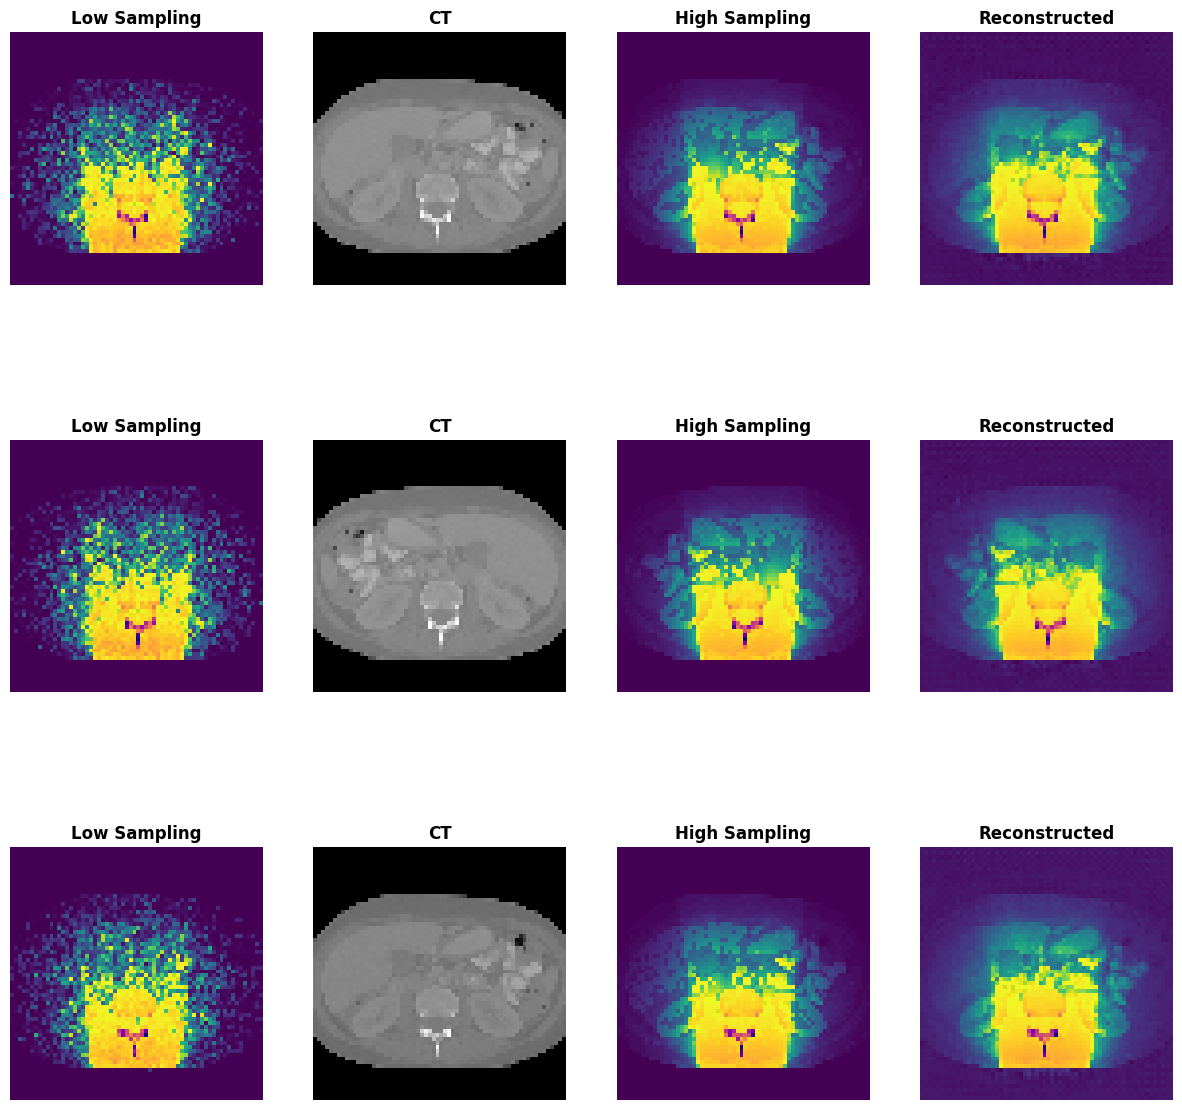

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Déplacez le modèle sur l'appareil approprié
model = model.to(device)

# Déplacez les données d'entrée sur le même appareil que le modèle
x_test = x_test.to(device)

# Effectuez la prédiction
model.eval()
with torch.no_grad():
    y_pred = model(x_test).cpu()  # Revenir sur CPU si nécessaire pour l'évaluation

y_pred2 = y_pred.cpu().squeeze(1).numpy()
y_test2 = y_test.cpu().squeeze(1).numpy()

fig, axes = plt.subplots(3, 4, figsize=(15, 15))

for i in range(3):
    axes[i, 0].imshow(x_test[i, 0].cpu().numpy(), cmap=newcmp)
    axes[i, 0].set_title('Low Sampling', fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(x_test[i, 1].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title('CT', fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_test2[i], cmap=newcmp)
    axes[i, 2].set_title('High Sampling', fontweight='bold')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(y_pred2[i], cmap=newcmp)
    axes[i, 3].set_title('Reconstructed', fontweight='bold')
    axes[i, 3].axis('off')

mean_psnr = np.mean([calculate_psnr(y_test2[i], y_pred2[i]) for i in range(len(y_test2))])
print(f"Mean PSNR: {mean_psnr:.2f} dB")